In [1]:
import cv2 as cv
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

In [2]:
SIZE = 150

# Playing with an image!

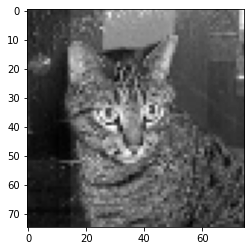

In [3]:
img = cv.imread('data/Cats and dogs/train/cat.1.jpg' , 0)
img = cv.resize(img , (75,75))
plt.imshow(img ,cmap='gray')



In [4]:
def procces_image(img_path):
    img = cv.imread(img_path ,0)
    img = cv.resize(img , (SIZE,SIZE))
    img = img.reshape(SIZE*SIZE)
    return img

In [5]:
def load_data(path):
    x = []
    y = []

    for file in os.listdir(path):
        label = file.split('.')[-3]
        data = procces_image("{}/{}".format(path,file))
        x.append(data)
        y.append(label)
    return x,y

In [6]:
X,Y = load_data('data/Cats and dogs/train')

In [7]:
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate = train_test_split(X,Y ,random_state=42)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

preprocess = Pipeline([
    ('scaler',MinMaxScaler()),
    ('pca',PCA(n_components=0.95)),
    ('shuffle' , shuffle(random_state=42))
])

In [10]:
x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eta=0.3,max_depth=10)
xgb_clf.fit(x_reduced,y_train)
xgb_clf.score(x_validate_reduced,y_validate)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

rf_clf.fit(x_reduced,y_train)
rf_clf.score(x_validate_reduced,y_validate)


In [ ]:
from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
gnb_clf.score(x_validate_reduced,y_validate)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=200,learning_rate=0.2)

ada_clf.fit(x_reduced,y_train)
ada_clf.score(x_validate_reduced,y_validate)